# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [2]:
# Import all of the necessary modules and functions
import matplotlib.pyplot as plt
import time
import random
import numpy as np
from numpy.linalg import inv
from cosmopower import cosmopower_NN
import emcee
from getdist import plots, MCSamples
from sklearn.decomposition import PCA

In [3]:
# This cell is for formatting plots, and can be commented out if it causes problems
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

In [5]:
cov=np.load('data_4_assignment3/covariance.npy') # load the analytic covariance matrix

minimum=np.load('data_4_assignment3/minimum.npy') # load the minimum model value for normalization
maximum=np.load('data_4_assignment3/maximum.npy') # load the maximum model value for normalization

models = np.load('data_4_assignment2/models.npy') # load the models that were used to train the emulator
reference_model = np.load('data_4_assignment3/reference_model.npy') # load the noiseless reference model for this analysis
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy') # load the noisy reference model for this analysis

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final') # load the emulator

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy') # load a numerical covariance matrix computed from 1500 samples
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy') # load a numerical covariance matrix computed from 3000 samples
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy') # load a numerical covariance matrix computed from 10000 samples

In [6]:
parameters = np.load('data_4_assignment2/parameters.npz') # load the parameters for the training models

# create a dictionary for the four model parameters
reference_params = {}
for name in parameters.keys():
    reference_params[name]=[]

In [7]:
total_steps = 3000 # total number of steps for each walker
burning_steps = 100 # number of buring steps to remove
nwalkers = 50 # number of walkers that probe the parameter space

num_threads = 10 # number of cpu cores to use

param_names_varying = ['omega_m', 'omega_b', 'As', 'w'] # paramters we want to vary
ndim = len(param_names_varying)
# print the maximum parameter ranges for reference
#for name in param_names_varying:
#    print(name,'\t',np.min(parameters[name]),'\t',np.max(parameters[name]))

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task that the posteriors and the $\chi^2$ distributions are as expected.
## Your tasks for this week are the following:

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.

In [8]:
# a function that distributes start postions inside the trained parameters
def start_position_lh_and_step_size():
    random.seed(time.perf_counter()) # select a random seed based on the clock time
    p0 = [] # array for starting positions
    # loop through each walker
    for i in range(nwalkers):
        random_starts = [] # starting position for this walker

        # set limits for the starting positions based on expected distributions from preliminary runs
        new_lim = {'omega_m':[0.3,0.4],'omega_b':[0.035,0.058],'As':[1.5e-9,2.5e-9],'w':[-1.3,-1.0]}
        # loop through each parameter that we vary
        for name in param_names_varying:
            # set the supper and lower bounds for the parameter starting position
            lower_edge = np.min(new_lim[name])
            upper_edge = np.max(new_lim[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge)) # set the random parameter starting position
        
        p0.append(random_starts)
    
    return np.array(p0) # return the starting positions for all of the walkers


# function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    # set a flat prior of 0
    lnprior = 0
    # if the walker is outside the emulator training range, set the prior to negative infinity
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior


# function that computes the likelihood
def calc_likelihood(para):
    
    params = reference_params # initialize an array for the parameters
    # loop through each of the parameters that we vary and record the current values
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0] # get the predicted vector from the trained emulator
    pred_vector = pred_vector*maximum+minimum # scale the normalized prediction
    
    delta = pred_vector - model # compute the difference between the reference model and the prediction vector
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta)) # compute the likelihood

    lnprior = cal_logprior(para_dict=params) # get the prior for these values

    return likelihood+lnprior # return the liklihood plus the prior


model = reference_model_noisy # set our model for the following quesitons to the noisy reference model

In [9]:
# a function that creates a triangle plot of the posteriors from MCMC samples
def plot_posteriors(samples,labels,title=False):
    # "samples" are the MCMC samples
    # "labels" are the names of the sample sets to be put in the legend
    # "title" is a flag for whether the mean values should be printed on the plot

    para_names = parameters.keys()
    param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

    para_priors = {}
    para_priors_low = {}
    para_priors_up = {}
    for name in para_names:
        para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
        para_priors_low[name] = np.min(parameters[name])
        para_priors_up[name] = np.max(parameters[name])

    samples_getdist = []
    for sample in samples:
        # get the distributions from the MCMC samples
        samples_getdist.append(MCSamples(samples=sample, names=param_names_latex, ranges=para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))

    g = plots.get_subplot_plotter(width_inch=12)
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_ls = '-'
    g.settings.title_limit_labels = False
    g.settings.axis_marker_color = 'k'
    g.settings.legend_colored_text = True
    g.settings.figure_legend_frame = False
    g.settings.linewidth = 2.0
    g.settings.linewidth_contour = 3.0
    g.settings.legend_fontsize = 22
    g.settings.axes_fontsize = 17
    g.settings.axes_labelsize = 22
    g.settings.axis_tick_x_rotation = 45
    g.settings.axis_tick_max_labels = 6
    g.settings.solid_colors = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

    if title:
        g.triangle_plot(
            roots=samples_getdist,
            filled=True,
            legend_loc='upper right',
            legend_labels = labels,
            markers=reference_params,
            title_limit=1
        )
    else:
        g.triangle_plot(
            roots=samples_getdist,
            filled=True,
            legend_loc='upper right',
            legend_labels = labels,
            markers=reference_params
        )



# a function that plots a chi^2 distribution from the MCMC log probabilities
def plot_chi2(log_prob_samples, labels):
    # "log_prob_samples" are the MCMC log probabilities
    # "labels" are the names of the sample sets to be put in the legend 

    chi2=-2*log_prob_samples # compute the chi^2 distribution

    colours = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']
    for i in range(len(log_prob_samples)):
        chi2=-2*log_prob_samples[i]
        plt.hist(chi2,bins=100,density=True, label=labels[i],color=colours[i],alpha=0.4)
    plt.xlabel('$\chi^2$')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

In [10]:
# MCMC with the analytic covariance matrix

cov_inv = inv(cov)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue',samples_covTrue)
log_prob_samples_covTrue = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue',log_prob_samples_covTrue)

100%|██████████| 3000/3000 [13:35<00:00,  3.68it/s]


In [11]:
#samples_covTrue = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue.npy')
#log_prob_samples_covTrue = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue.npy')

Removed no burn in


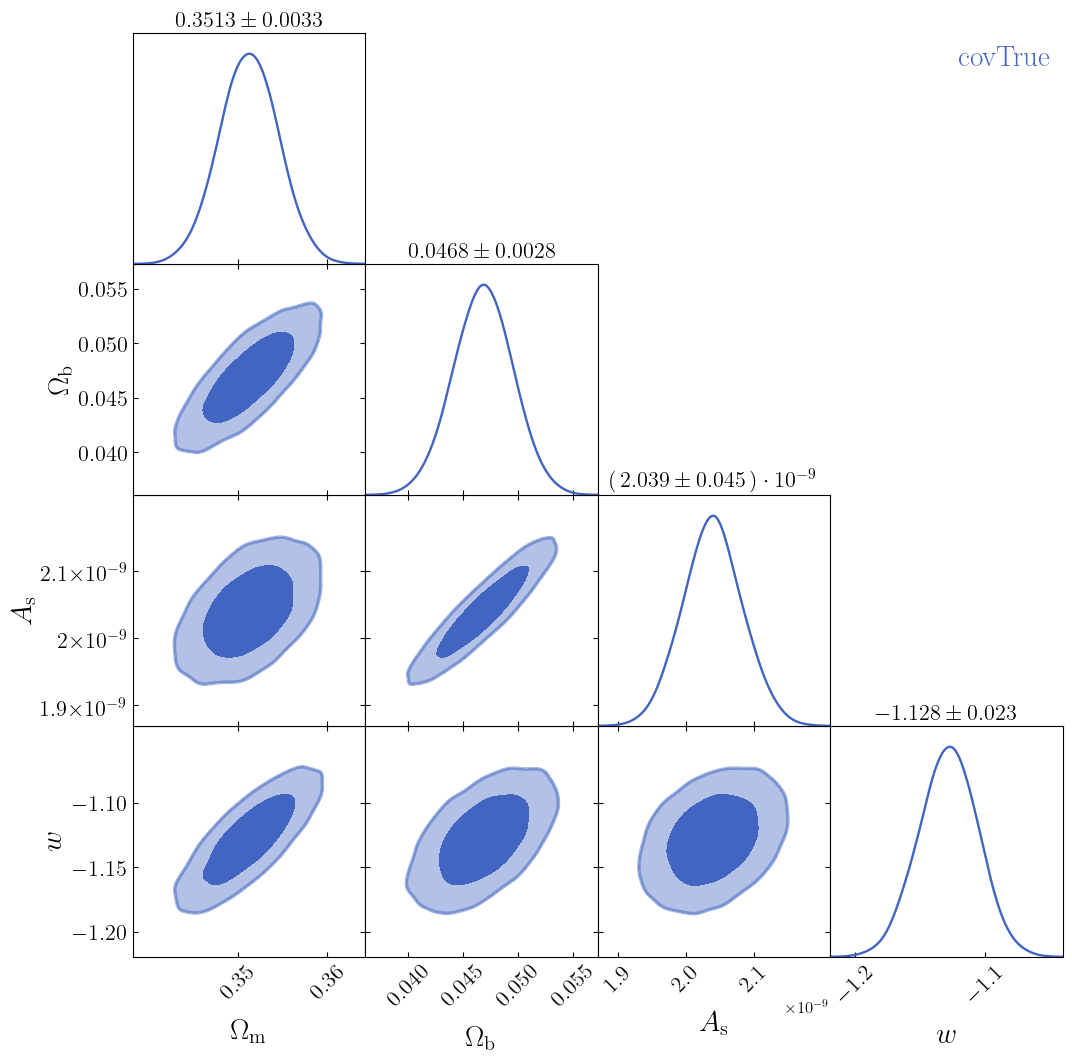

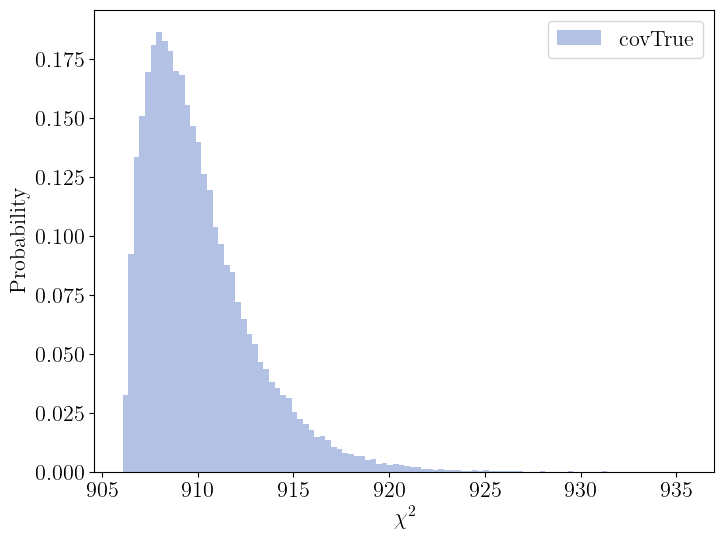

In [12]:
# plots for the analytic covariance matrix

plot_posteriors([samples_covTrue],
                labels=['covTrue'],title=True)
plt.savefig('data_4_assignment3/plots/covTrue_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue],
          labels=['covTrue'])
plt.savefig('data_4_assignment3/plots/covTrue_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

In [13]:
# MCMC with the numerical covariance matrix from 1500 vectors

cov_inv = inv(cov_num_1500)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500',samples_cov1500)
log_prob_samples_cov1500 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500',log_prob_samples_cov1500)

100%|██████████| 3000/3000 [11:29<00:00,  4.35it/s]


In [14]:
# MCMC with the numerical covariance matrix from 1500 vectors with the Hartlap factor

n_r = int(1500)
n_d = len(cov_num_1500)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_1500)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_hart',samples_cov1500_hart)
log_prob_samples_cov1500_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_hart',log_prob_samples_cov1500_hart)

100%|██████████| 3000/3000 [11:33<00:00,  4.32it/s]


In [15]:
# MCMC with the numerical covariance matrix from 3000 vectors

cov_inv = inv(cov_num_3000)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov3000 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov3000',samples_cov3000)
log_prob_samples_cov3000 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov3000',log_prob_samples_cov3000)

100%|██████████| 3000/3000 [11:22<00:00,  4.40it/s]


In [16]:
# MCMC with the numerical covariance matrix from 3000 vectors with the Hartlap factor

n_r = int(3000)
n_d = len(cov_num_3000)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_3000)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov3000_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov3000_hart',samples_cov3000_hart)
log_prob_samples_cov3000_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov3000_hart',log_prob_samples_cov3000_hart)

100%|██████████| 3000/3000 [11:48<00:00,  4.24it/s]


In [17]:
# MCMC with the numerical covariance matrix from 10000 vectors

cov_inv = inv(cov_num_10000)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov10000 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov10000',samples_cov10000)
log_prob_samples_cov10000 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov10000',log_prob_samples_cov10000)

100%|██████████| 3000/3000 [12:25<00:00,  4.03it/s]


In [18]:
# MCMC with the numerical covariance matrix from 10000 vectors with the Hartlap factor

n_r = int(10000)
n_d = len(cov_num_10000)
h = (n_r-1)/(n_r-n_d-2)
cov_inv = inv(cov_num_10000)/h

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov10000_hart = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov10000_hart',samples_cov10000_hart)
log_prob_samples_cov10000_hart = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov10000_hart',log_prob_samples_cov10000_hart)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [11:46<00:00,  4.25it/s]


In [19]:
#samples_cov1500 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500.npy')
#samples_cov3000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov3000.npy')
#samples_cov10000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov10000.npy')
#samples_cov1500_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_hart.npy')
#samples_cov3000_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov3000_hart.npy')
#samples_cov10000_hart = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov10000_hart.npy')
#
#log_prob_samples_cov1500 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500.npy')
#log_prob_samples_cov3000 = np.load('data_4_assignment3/outputs_MCMC/logp_cov3000.npy')
#log_prob_samples_cov10000 = np.load('data_4_assignment3/outputs_MCMC/logp_cov10000.npy')
#log_prob_samples_cov1500_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_hart.npy')
#log_prob_samples_cov3000_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov3000_hart.npy')
#log_prob_samples_cov10000_hart = np.load('data_4_assignment3/outputs_MCMC/logp_cov10000_hart.npy')

Removed no burn in
Removed no burn in
Removed no burn in


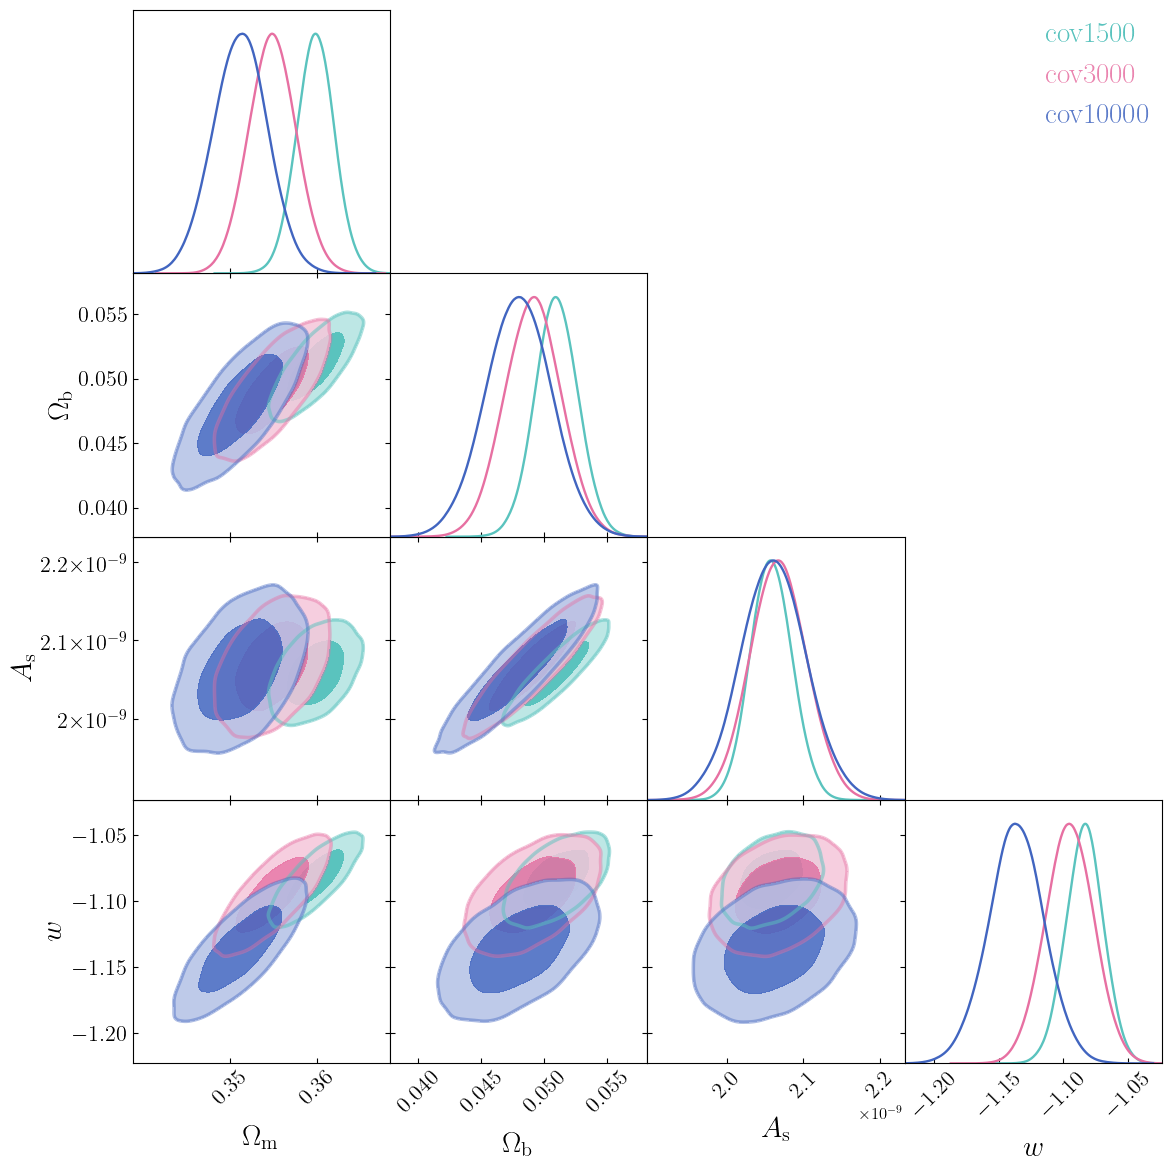

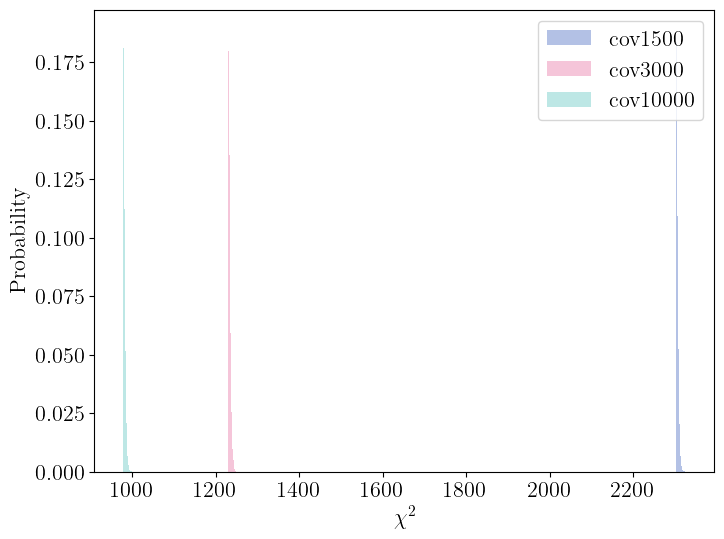

In [20]:
# plots for the three numerical covariance matricies

plot_posteriors([samples_cov1500, samples_cov3000, samples_cov10000],
                labels=['cov1500','cov3000','cov10000'])
plt.savefig('data_4_assignment3/plots/covNum_noHart_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500,log_prob_samples_cov3000,log_prob_samples_cov10000],
           labels=['cov1500','cov3000','cov10000'])
plt.savefig('data_4_assignment3/plots/covNum_noHart_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


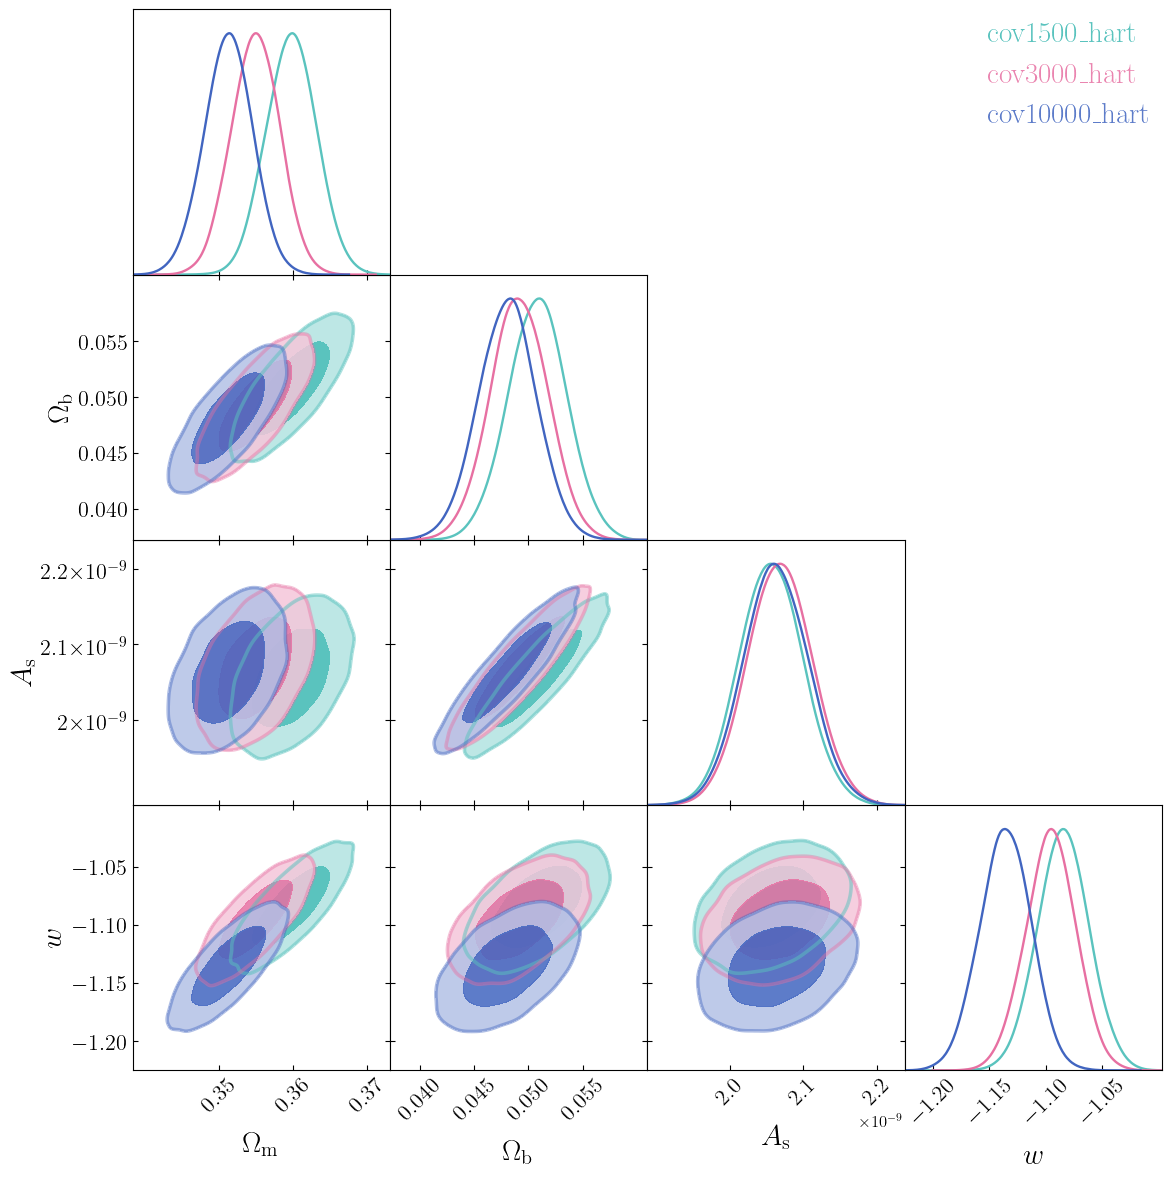

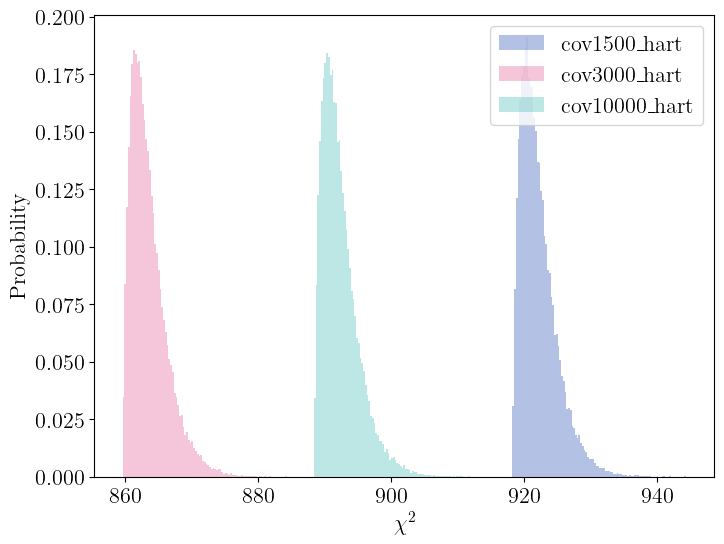

In [21]:
# plots for the three numerical covariance matricies with the Hartlap factor

plot_posteriors([samples_cov1500_hart, samples_cov3000_hart, samples_cov10000_hart],
                labels=['cov1500_hart','cov3000_hart','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/covNum_hart_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_hart,log_prob_samples_cov3000_hart,log_prob_samples_cov10000_hart],
           labels=['cov1500_hart','cov3000_hart','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/covNum_hart_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


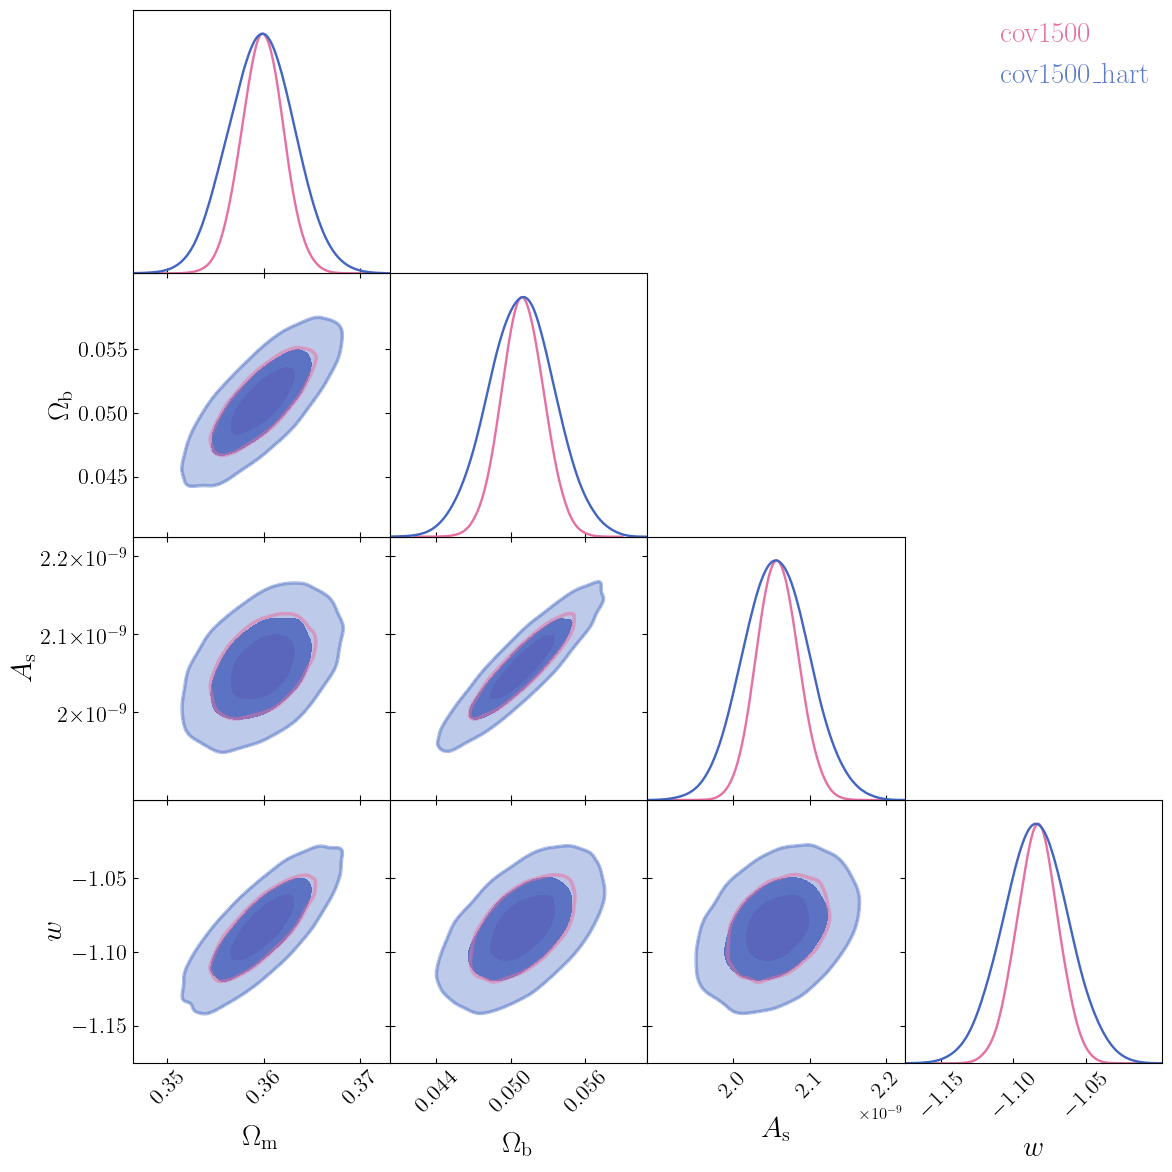

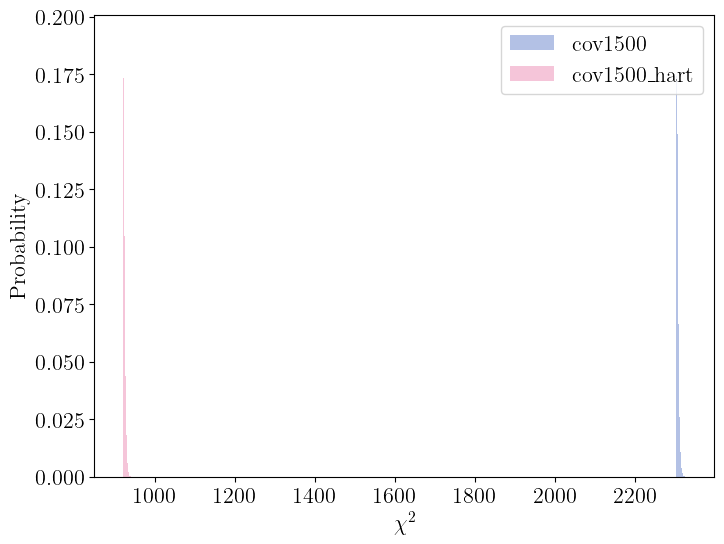

In [22]:
# plots for the numerical covariance matrix from 1500 vectors with and without the Hartlap factor

plot_posteriors([samples_cov1500, samples_cov1500_hart],
                labels=['cov1500','cov1500_hart'])
plt.savefig('data_4_assignment3/plots/cov1500_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500,log_prob_samples_cov1500_hart],
           labels=['cov1500','cov1500_hart'])
plt.savefig('data_4_assignment3/plots/cov1500_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


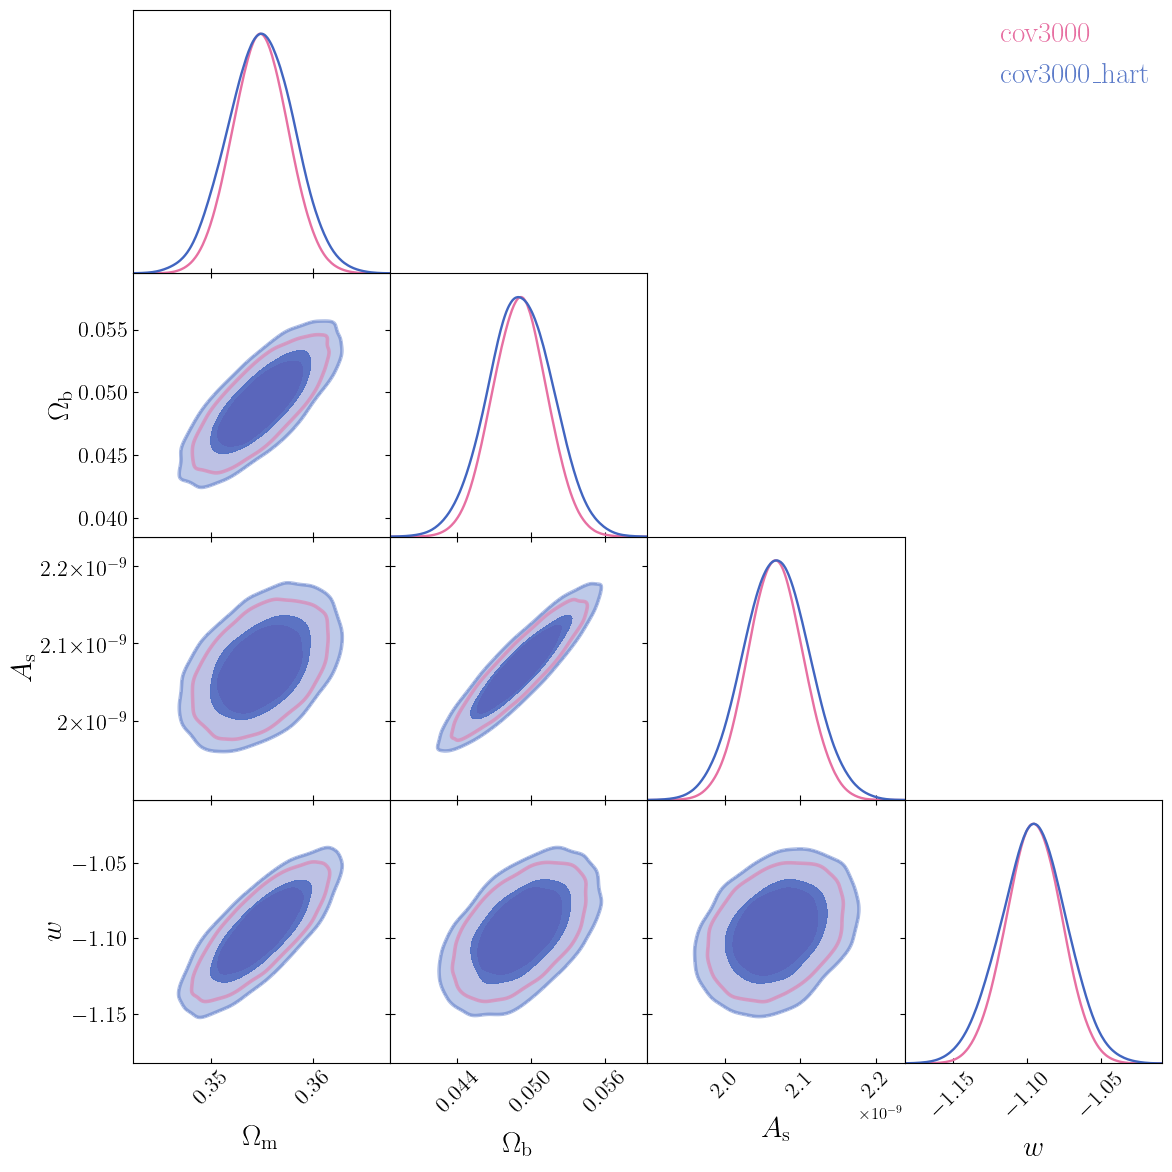

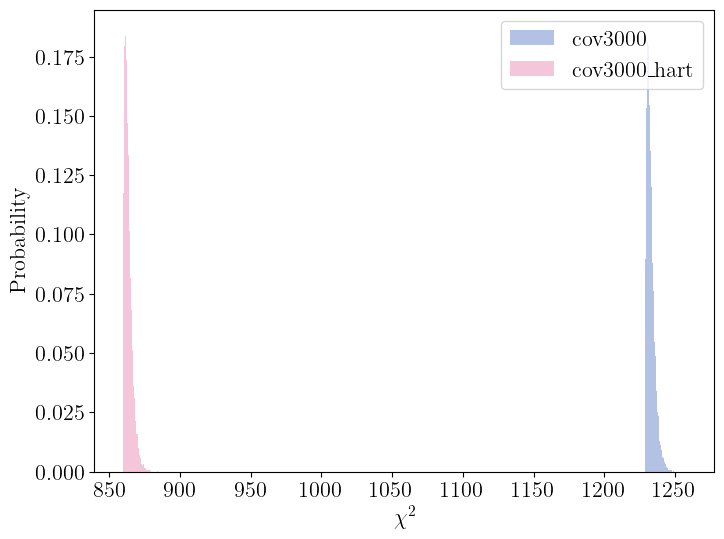

In [23]:
# plots for the numerical covariance matrix from 3000 vectors with and without the Hartlap factor

plot_posteriors([samples_cov3000, samples_cov3000_hart],
                labels=['cov3000','cov3000_hart'])
plt.savefig('data_4_assignment3/plots/cov3000_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov3000,log_prob_samples_cov3000_hart],
           labels=['cov3000','cov3000_hart'])
plt.savefig('data_4_assignment3/plots/cov3000_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in


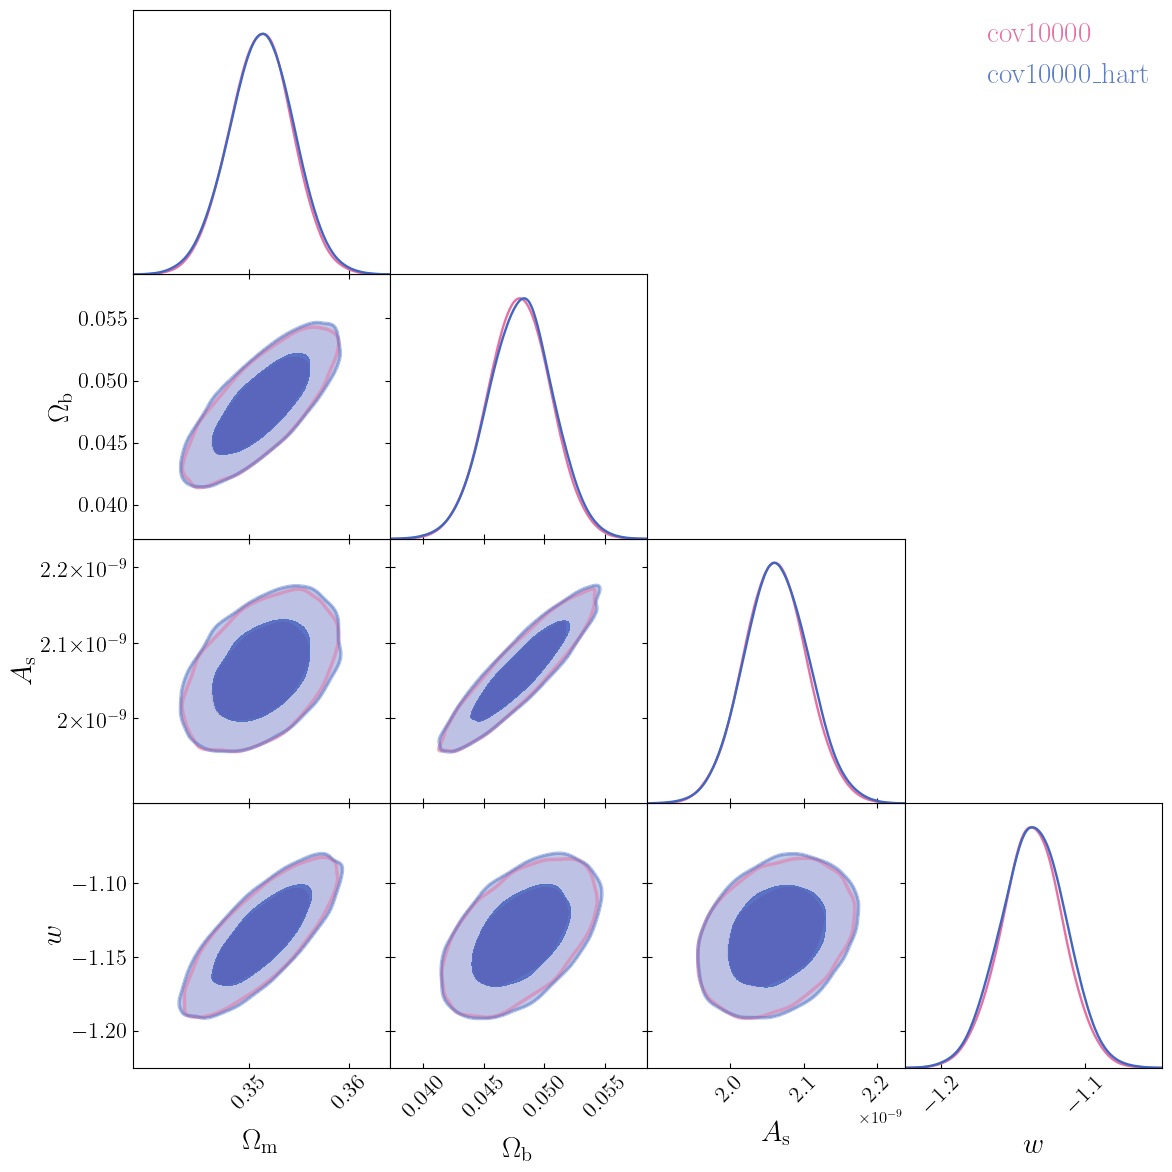

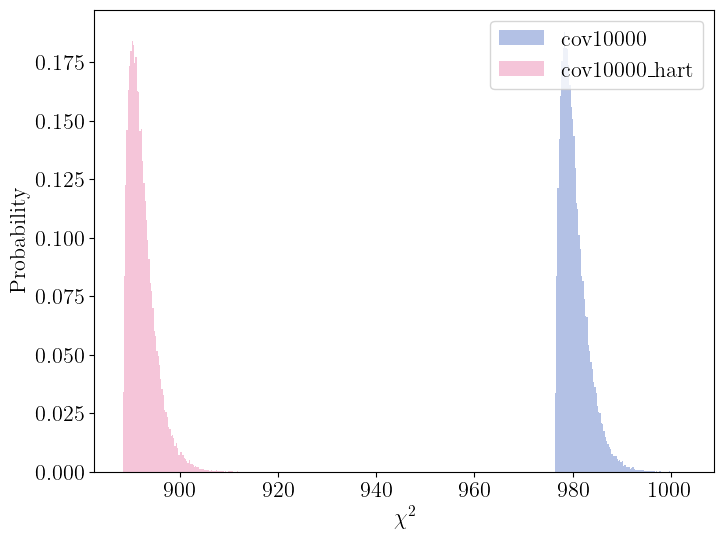

In [24]:
# plots for the numerical covariance matrix from 10000 vectors with and without the Hartlap factor

plot_posteriors([samples_cov10000, samples_cov10000_hart],
                labels=['cov10000','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/cov10000_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov10000,log_prob_samples_cov10000_hart],
           labels=['cov10000','cov10000_hart'])
plt.savefig('data_4_assignment3/plots/cov10000_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.

####    3.a. Use the analytical covariance matrix.

In [25]:
# function that computes the likelihood with a PCA transformation
def calc_likelihood_pca(para):
    
    params = reference_params # initialize an array for the parameters
    # loop through each of the parameters that we vary and record the current values
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0] # get the predicted vector from the trained emulator
    pred_vector = pred_vector*maximum+minimum # scale the normalized prediction
    pred_vector_pca = pca.transform([pred_vector-mean])[0] # transform the prediction vector using a fitted PCA
    
    delta = pred_vector_pca - model # compute the difference between the reference model and the prediction vector
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta)) # compute the likelihood

    lnprior = cal_logprior(para_dict=params) # get the prior for these values

    return likelihood+lnprior # return the liklihood plus the prior


# a function that computes and returns a trained PCA, transformed reference model and rotated covariance matrix
def make_pca_parts(N_pca,covariance,reference,hart):
    # "N_pca" is the number of PCA eigenvalues to use
    # "covariance" is the covariance matrix to be rotated
    # "reference" is the reference model to be transformed
    # "hart" is a flag for whether to scale by the Hartlap factor

    pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
    pca.fit(models-mean) # perform the PCA fitting

    rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
    cov_pca = rotation_matrix.T @ covariance @ rotation_matrix # rotate covariance matrix

    reference_pca = pca.transform([reference-mean])[0] # transform the reference model minus the mean using the fitted PCA
    cov_inv = inv(cov_pca) # invert the rotated covariance matrix

    # if we're using the Hartlap factor, correct the inverse covariance matrix by it
    if hart:
        cov_inv /= h

    # return the fitted PCA, the tranformed reference model, and the rotated inverse covariance matrix
    return pca,reference_pca,cov_inv


# for numerical stability, compute the mean of each element from the model vectors to be subtracted off later
mean = np.mean(models,axis=0)

# pre-compute the Hartlap factor to be used later
n_r = int(1500)
n_d = len(cov_num_1500)
h = (n_r-1)/(n_r-n_d-2)

In [26]:
# MCMC with the analytic covariance matrix and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca100 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100',samples_covTrue_pca100)
log_prob_samples_covTrue_pca100 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100',log_prob_samples_covTrue_pca100)

100%|██████████| 3000/3000 [12:29<00:00,  4.00it/s]


In [27]:
# MCMC with the analytic covariance matrix and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca300 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300',samples_covTrue_pca300)
log_prob_samples_covTrue_pca300 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300',log_prob_samples_covTrue_pca300)

100%|██████████| 3000/3000 [12:24<00:00,  4.03it/s]


In [28]:
# MCMC with the analytic covariance matrix and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca600 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600',samples_covTrue_pca600)
log_prob_samples_covTrue_pca600 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600',log_prob_samples_covTrue_pca600)

100%|██████████| 3000/3000 [12:21<00:00,  4.04it/s]


In [29]:
# MCMC with the analytic covariance matrix and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov,reference_model_noisy,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca900 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900',samples_covTrue_pca900)
log_prob_samples_covTrue_pca900 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900',log_prob_samples_covTrue_pca900)

100%|██████████| 3000/3000 [13:09<00:00,  3.80it/s]


In [30]:
#samples_covTrue_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100.npy')
#samples_covTrue_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300.npy')
#samples_covTrue_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600.npy')
#samples_covTrue_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900.npy')
#
#log_prob_samples_covTrue_pca100 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100.npy')
#log_prob_samples_covTrue_pca300 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300.npy')
#log_prob_samples_covTrue_pca600 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600.npy')
#log_prob_samples_covTrue_pca900 = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


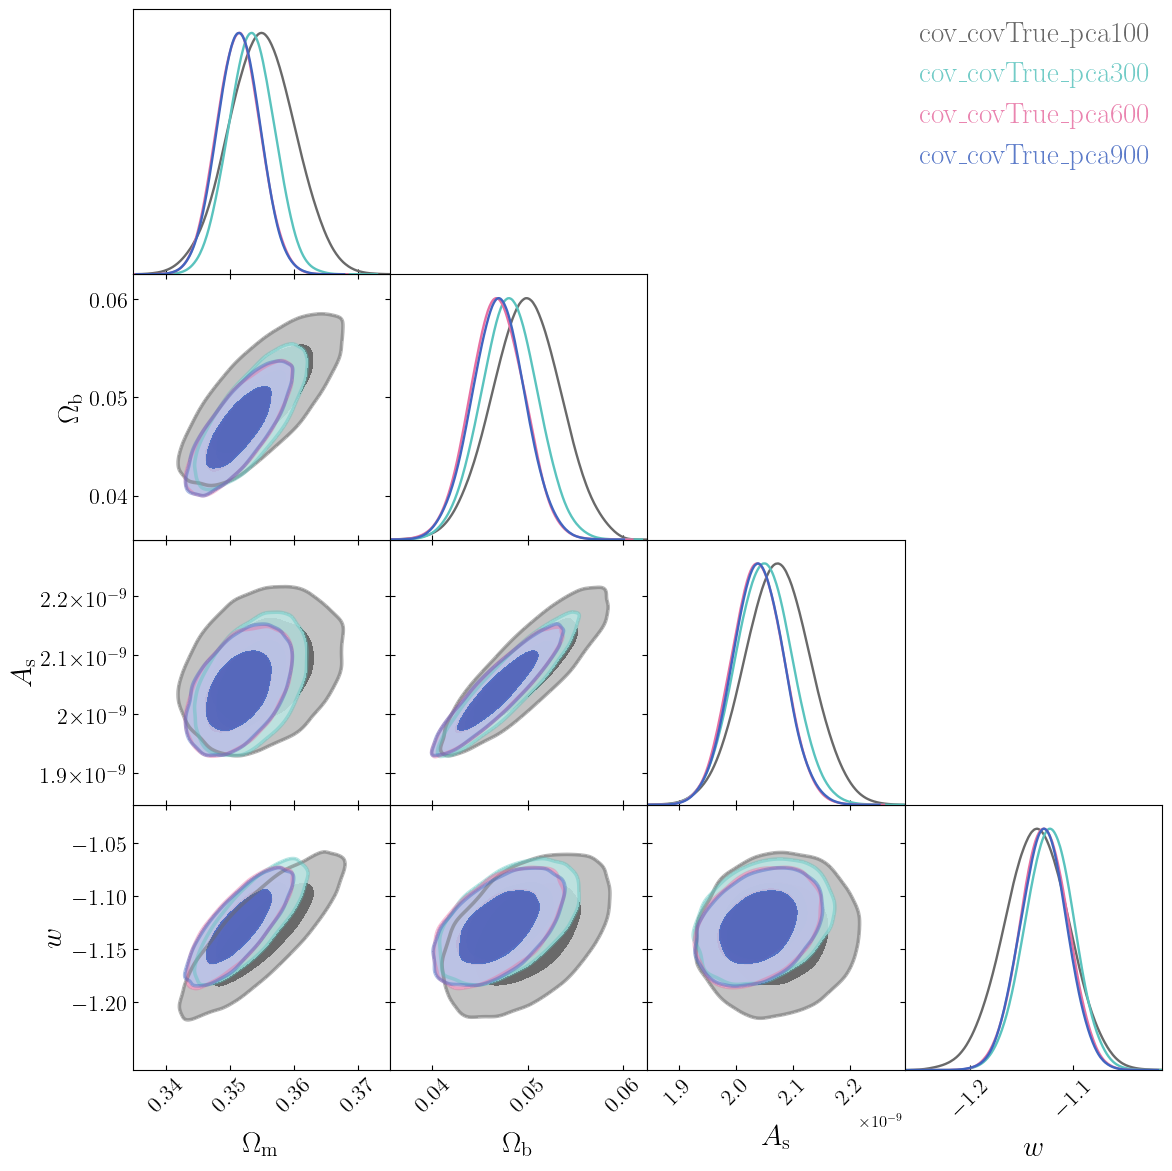

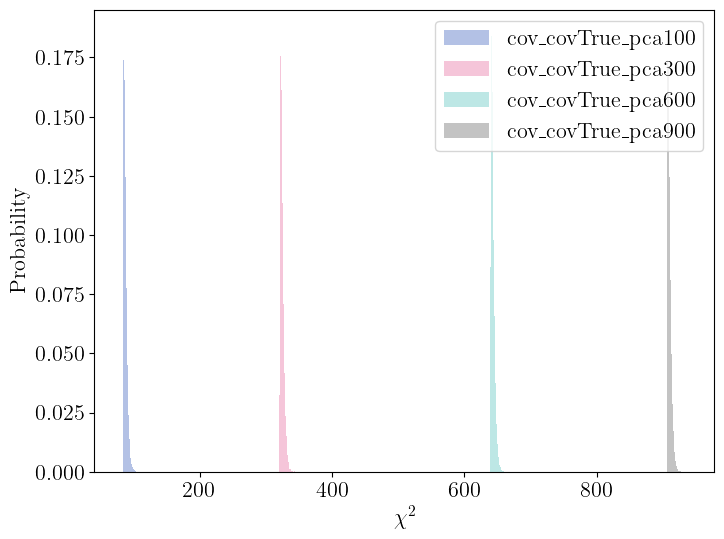

In [31]:
# plots for the analytic covariance matrix with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_covTrue_pca100,samples_covTrue_pca300,samples_covTrue_pca600,samples_covTrue_pca900],
                labels=['cov_covTrue_pca100','cov_covTrue_pca300','cov_covTrue_pca600','cov_covTrue_pca900'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue_pca100,log_prob_samples_covTrue_pca300,log_prob_samples_covTrue_pca600,log_prob_samples_covTrue_pca900],
           labels=['cov_covTrue_pca100','cov_covTrue_pca300','cov_covTrue_pca600','cov_covTrue_pca900'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

In [32]:
# MCMC with the numerical covariance matrix from 1500 vectors and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca100 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100',samples_cov1500_pca100)
log_prob_samples_cov1500_pca100 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100',log_prob_samples_cov1500_pca100)

100%|██████████| 3000/3000 [12:27<00:00,  4.01it/s]


In [33]:
# MCMC with the numerical covariance matrix from 1500 vectors and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca300 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300',samples_cov1500_pca300)
log_prob_samples_cov1500_pca300 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300',log_prob_samples_cov1500_pca300)

100%|██████████| 3000/3000 [12:25<00:00,  4.03it/s]


In [34]:
# MCMC with the numerical covariance matrix from 1500 vectors and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca600 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600',samples_cov1500_pca600)
log_prob_samples_cov1500_pca600 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600',log_prob_samples_cov1500_pca600)

100%|██████████| 3000/3000 [12:25<00:00,  4.03it/s]


In [35]:
# MCMC with the numerical covariance matrix from 1500 vectors and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov_num_1500,reference_model_noisy,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca900 = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900',samples_cov1500_pca900)
log_prob_samples_cov1500_pca900 = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900',log_prob_samples_cov1500_pca900)

100%|██████████| 3000/3000 [13:13<00:00,  3.78it/s]


In [36]:
#samples_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100.npy')
#samples_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300.npy')
#samples_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600.npy')
#samples_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900.npy')
#
#log_prob_samples_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100.npy')
#log_prob_samples_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300.npy')
#log_prob_samples_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600.npy')
#log_prob_samples_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


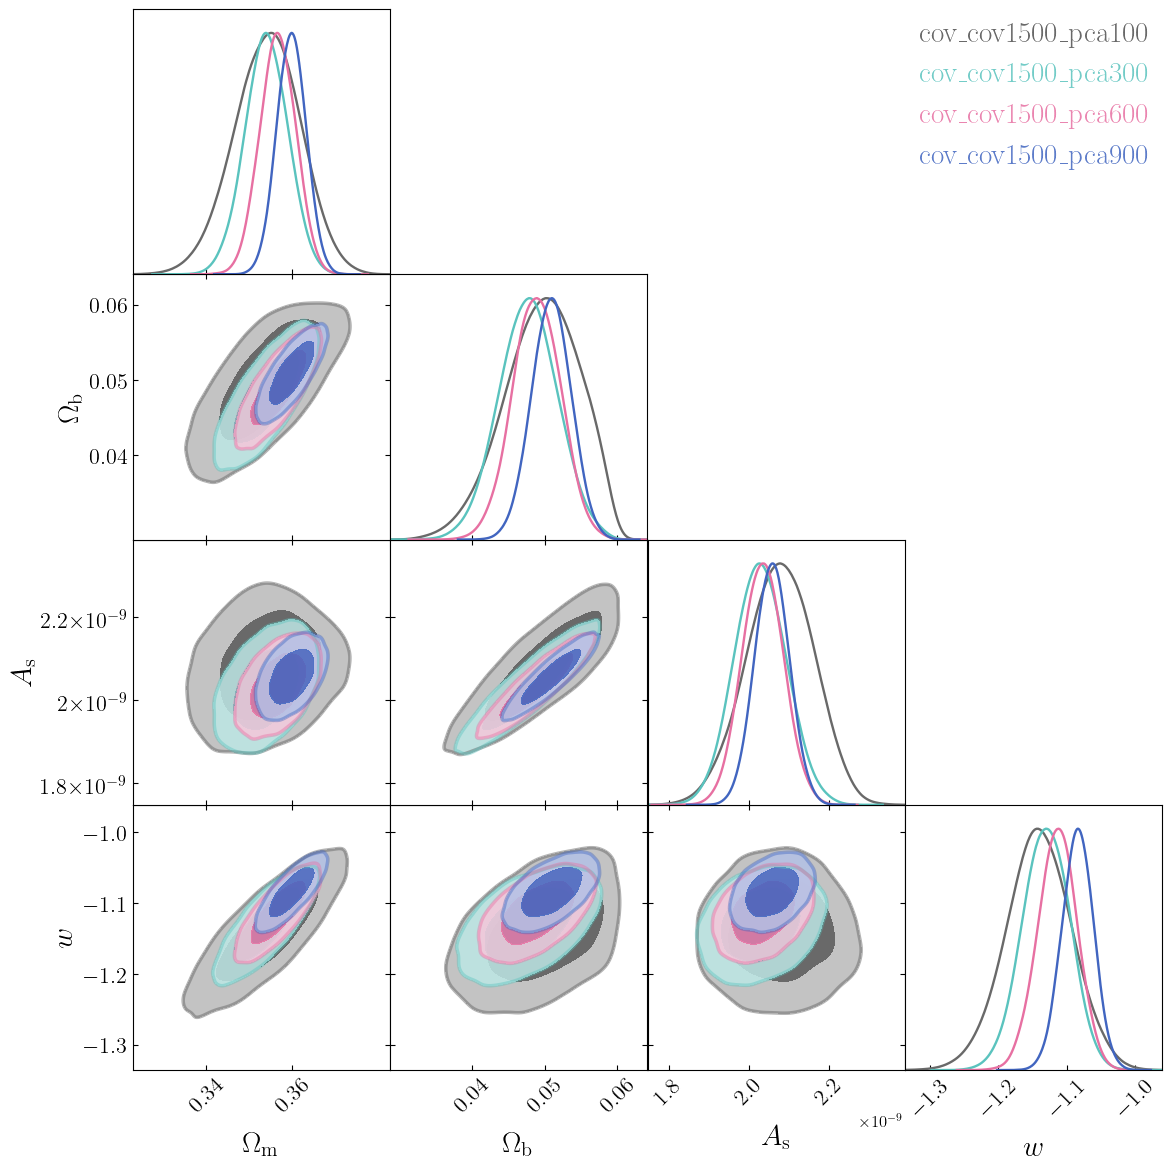

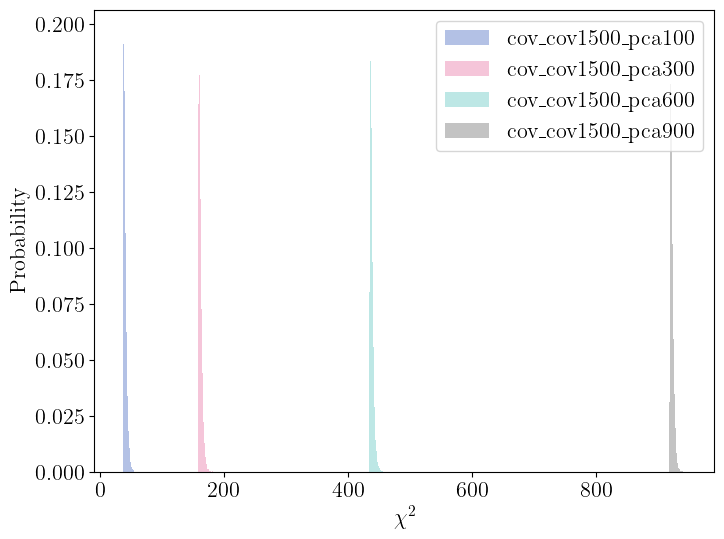

In [37]:
# plots for the numerical covariance matrix from 1500 vectors with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_cov1500_pca100,samples_cov1500_pca300,samples_cov1500_pca600,samples_cov1500_pca900],
                labels=['cov_cov1500_pca100','cov_cov1500_pca300','cov_cov1500_pca600','cov_cov1500_pca900'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_pca100,log_prob_samples_cov1500_pca300,log_prob_samples_cov1500_pca600,log_prob_samples_cov1500_pca900],
           labels=['cov_cov1500_pca100','cov_cov1500_pca300','cov_cov1500_pca600','cov_cov1500_pca900'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?

In [38]:
# MCMC with the analytic covariance matrix, noiseless reference model and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca100_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100_clean',samples_covTrue_pca100_clean)
log_prob_samples_covTrue_pca100_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100_clean',log_prob_samples_covTrue_pca100_clean)

100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s]


In [39]:
# MCMC with the analytic covariance matrix, noiseless reference model and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca300_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300_clean',samples_covTrue_pca300_clean)
log_prob_samples_covTrue_pca300_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300_clean',log_prob_samples_covTrue_pca300_clean)

100%|██████████| 3000/3000 [12:27<00:00,  4.01it/s]


In [40]:
# MCMC with the analytic covariance matrix, noiseless reference model and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca600_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600_clean',samples_covTrue_pca600_clean)
log_prob_samples_covTrue_pca600_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600_clean',log_prob_samples_covTrue_pca600_clean)

100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


In [41]:
# MCMC with the analytic covariance matrix, noiseless reference model and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov,reference_model,False)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_covTrue_pca900_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900_clean',samples_covTrue_pca900_clean)
log_prob_samples_covTrue_pca900_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900_clean',log_prob_samples_covTrue_pca900_clean)

100%|██████████| 3000/3000 [13:04<00:00,  3.82it/s]


In [42]:
#samples_covTrue_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca100_clean.npy')
#samples_covTrue_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca300_clean.npy')
#samples_covTrue_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca600_clean.npy')
#samples_covTrue_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_covTrue_pca900_clean.npy')
#
#log_prob_samples_covTrue_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca100_clean.npy')
#log_prob_samples_covTrue_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca300_clean.npy')
#log_prob_samples_covTrue_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca600_clean.npy')
#log_prob_samples_covTrue_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/logp_covTrue_pca900_clean.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


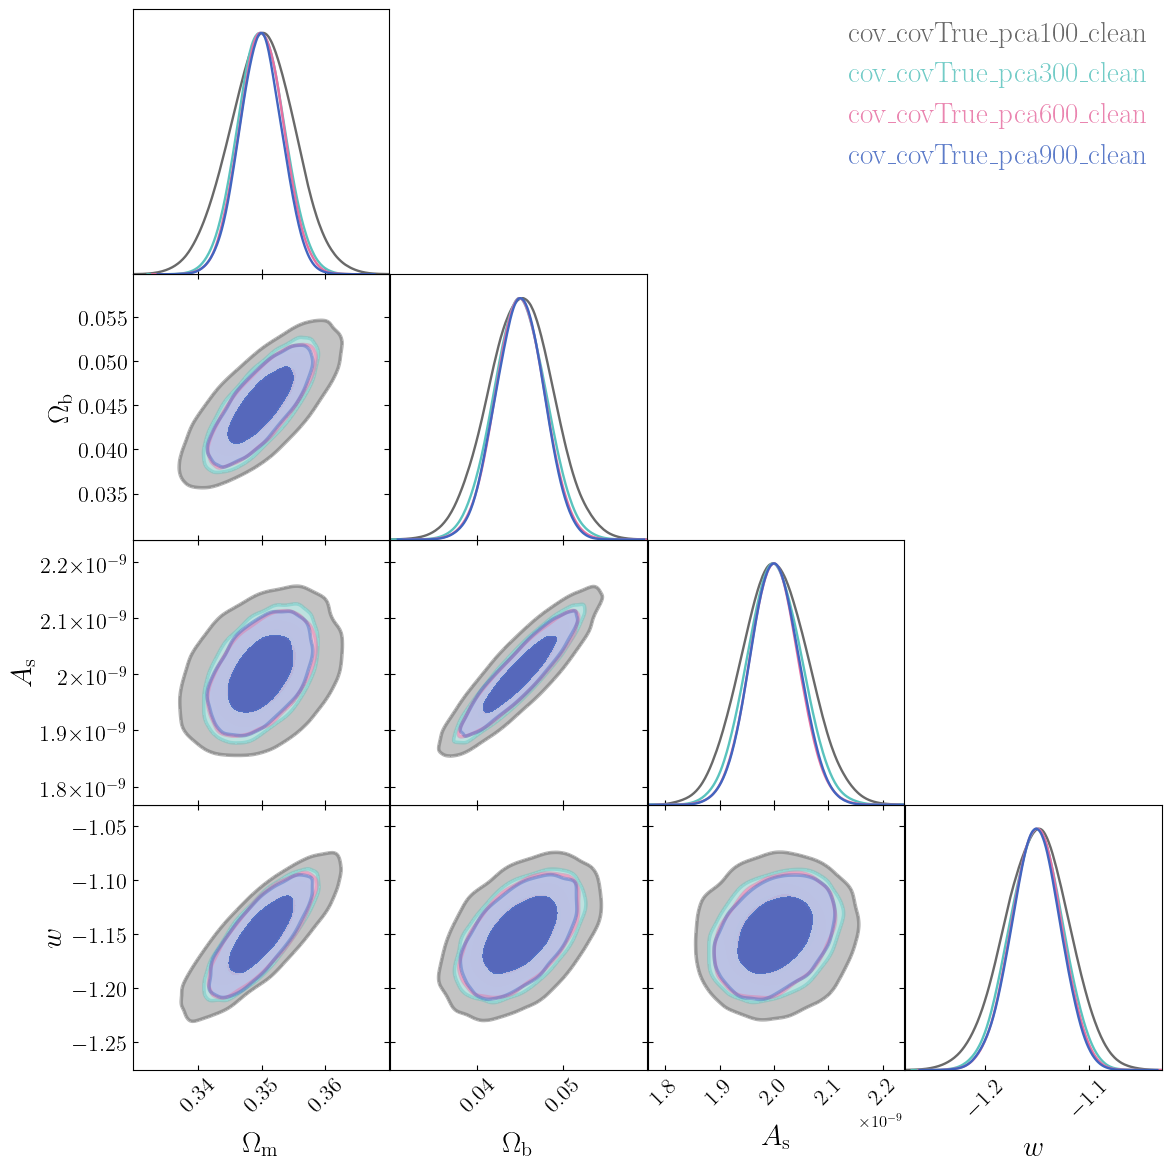

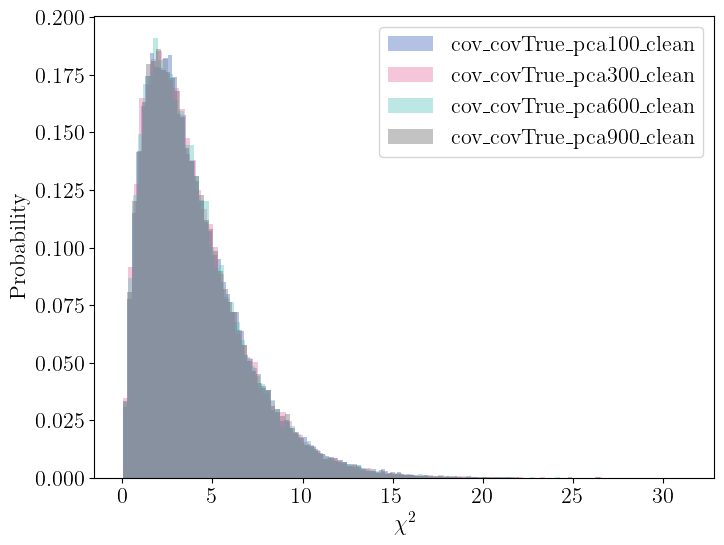

In [43]:
# plots for the analytic covariance matrix and noiseless reference model with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_covTrue_pca100_clean,samples_covTrue_pca300_clean,samples_covTrue_pca600_clean,samples_covTrue_pca900_clean],
                labels=['cov_covTrue_pca100_clean','cov_covTrue_pca300_clean','cov_covTrue_pca600_clean','cov_covTrue_pca900_clean'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_noNoise_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_covTrue_pca100_clean,log_prob_samples_covTrue_pca300_clean,log_prob_samples_covTrue_pca600_clean,log_prob_samples_covTrue_pca900_clean],
           labels=['cov_covTrue_pca100_clean','cov_covTrue_pca300_clean','cov_covTrue_pca600_clean','cov_covTrue_pca900_clean'])
plt.savefig('data_4_assignment3/plots/covTrue_pca_noNoise_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

In [44]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 100 PCA elements

pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca100_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100_clean',samples_cov1500_pca100_clean)
log_prob_samples_cov1500_pca100_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100_clean',log_prob_samples_cov1500_pca100_clean)

100%|██████████| 3000/3000 [12:37<00:00,  3.96it/s]


In [45]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 300 PCA elements

pca,model,cov_inv = make_pca_parts(300,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca300_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300_clean',samples_cov1500_pca300_clean)
log_prob_samples_cov1500_pca300_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300_clean',log_prob_samples_cov1500_pca300_clean)

100%|██████████| 3000/3000 [12:24<00:00,  4.03it/s]


In [46]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 600 PCA elements

pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca600_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600_clean',samples_cov1500_pca600_clean)
log_prob_samples_cov1500_pca600_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600_clean',log_prob_samples_cov1500_pca600_clean)

100%|██████████| 3000/3000 [12:16<00:00,  4.07it/s]


In [47]:
# MCMC with the numerical covariance matrix from 1500 vectors, noiseless reference model and 900 PCA elements

pca,model,cov_inv = make_pca_parts(900,cov_num_1500,reference_model,True)

p0 = start_position_lh_and_step_size()

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_cov1500_pca900_clean = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900_clean',samples_cov1500_pca900_clean)
log_prob_samples_cov1500_pca900_clean = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900_clean',log_prob_samples_cov1500_pca900_clean)

100%|██████████| 3000/3000 [13:03<00:00,  3.83it/s]


In [48]:
#samples_cov1500_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca100_clean.npy')
#samples_cov1500_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca300_clean.npy')
#samples_cov1500_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca600_clean.npy')
#samples_cov1500_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/MCMC_cov1500_pca900_clean.npy')
#
#log_prob_samples_cov1500_pca100_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca100_clean.npy')
#log_prob_samples_cov1500_pca300_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca300_clean.npy')
#log_prob_samples_cov1500_pca600_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca600_clean.npy')
#log_prob_samples_cov1500_pca900_clean = np.load('data_4_assignment3/outputs_MCMC/logp_cov1500_pca900_clean.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


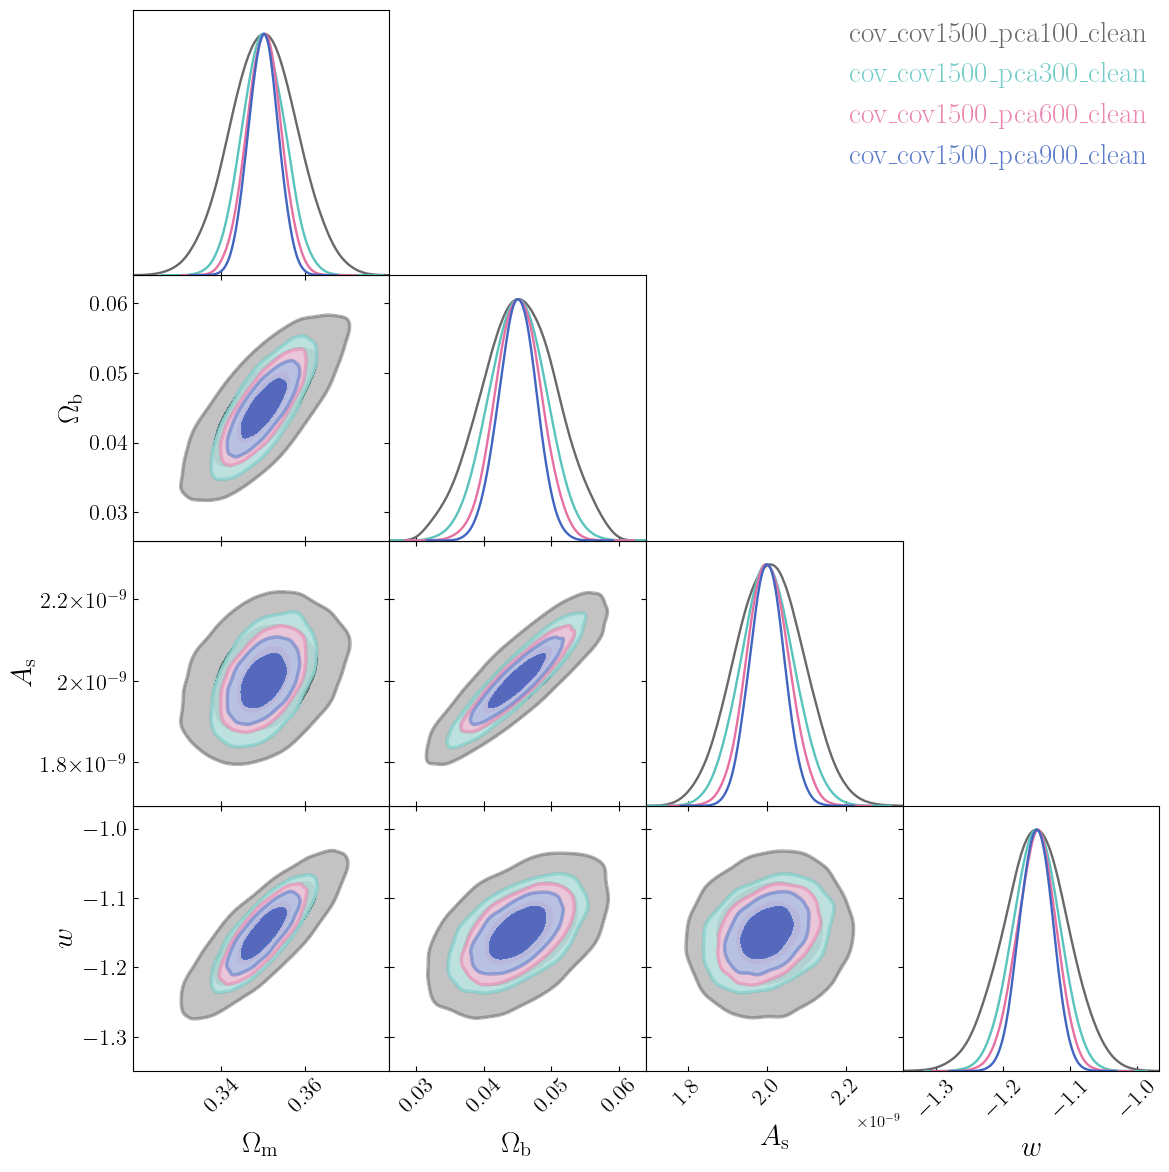

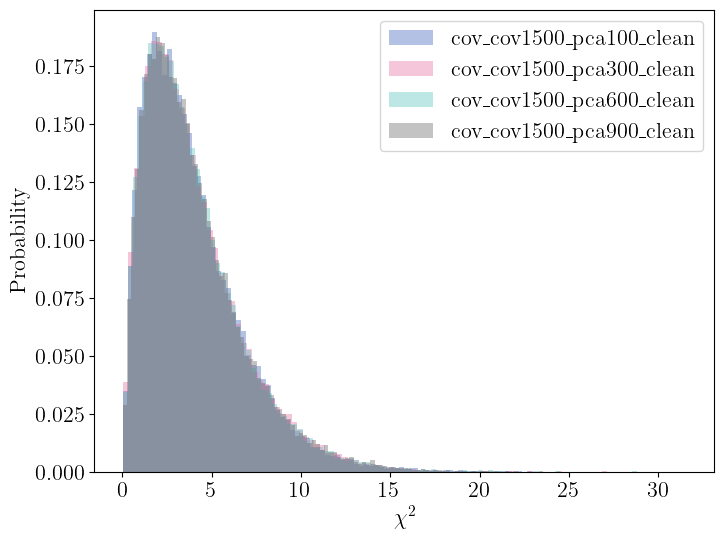

In [49]:
# plots for the numerical covariance matrix from 1500 vectors and noiseless reference model with 100, 300, 600 and 900 PCA elements

plot_posteriors([samples_cov1500_pca100_clean,samples_cov1500_pca300_clean,samples_cov1500_pca600_clean,samples_cov1500_pca900_clean],
                labels=['cov_cov1500_pca100_clean','cov_cov1500_pca300_clean','cov_cov1500_pca600_clean','cov_cov1500_pca900_clean'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_noNoise_posteriors.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plot_chi2([log_prob_samples_cov1500_pca100_clean,log_prob_samples_cov1500_pca300_clean,log_prob_samples_cov1500_pca600_clean,log_prob_samples_cov1500_pca900_clean],
           labels=['cov_cov1500_pca100_clean','cov_cov1500_pca300_clean','cov_cov1500_pca600_clean','cov_cov1500_pca900_clean'])
plt.savefig('data_4_assignment3/plots/cov1500_pca_noNoise_chi2.jpg',dpi=600, bbox_inches='tight')
plt.show()

#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?

In [50]:
parameter_constraints = [] # initialize an array for parameter constraints

N_pcas = [2,3,4,5,7,10,15,25,40,70,100,200,300,500,700,900] # numbers of PCA elements for which to compute the contraints

for N_pca in N_pcas:
    pca,model,cov_inv = make_pca_parts(N_pca,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size()

    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]]
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]])

    parameter_constraints.append([means,sigmas])

parameter_constraints = np.array(parameter_constraints)

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints',parameter_constraints)

100%|██████████| 3000/3000 [11:14<00:00,  4.45it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:18<00:00,  4.42it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:24<00:00,  4.38it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:06<00:00,  4.50it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:18<00:00,  4.42it/s]


Removed no burn in


100%|██████████| 3000/3000 [11:18<00:00,  4.42it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:12<00:00,  4.09it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:17<00:00,  4.07it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:20<00:00,  4.05it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:14<00:00,  4.08it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:27<00:00,  4.01it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:42<00:00,  3.94it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:26<00:00,  4.02it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:16<00:00,  4.07it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:43<00:00,  3.93it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:06<00:00,  3.81it/s]

Removed no burn in


In [51]:
#parameter_constraints = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints.npy')

omega_m_means = parameter_constraints[:,0,0]
As_means = parameter_constraints[:,0,1]
omega_m_sigmas = parameter_constraints[:,1,0]
As_sigmas = parameter_constraints[:,1,1]

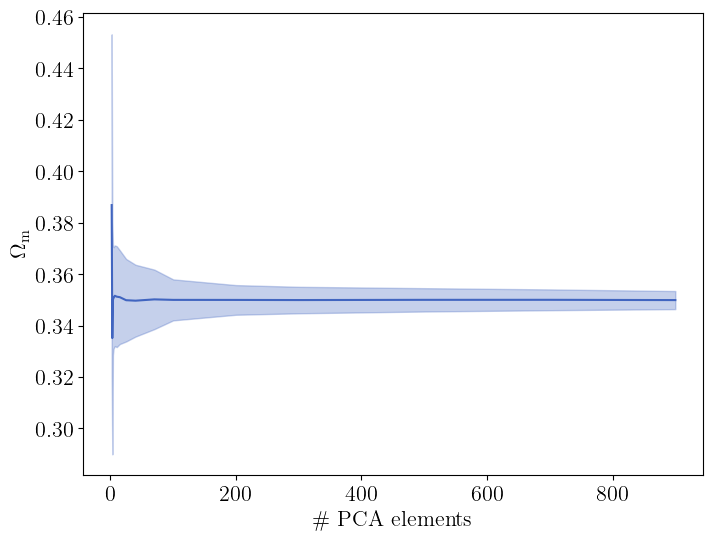

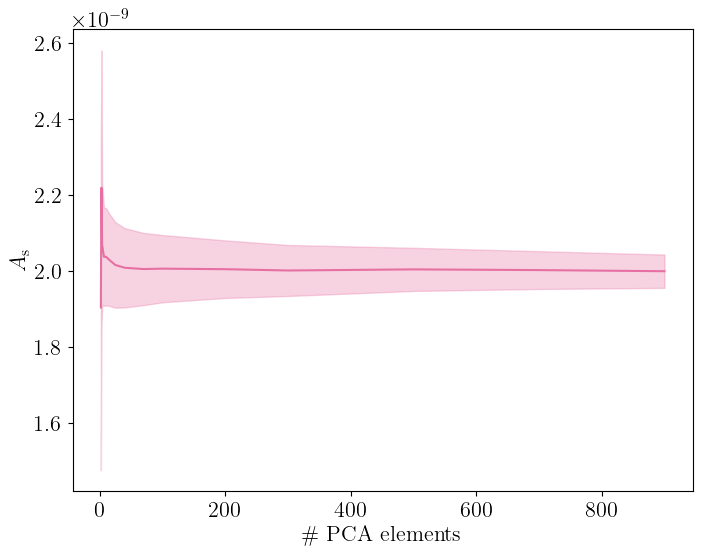

In [52]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas,omega_m_means,color='#4165c0')
plt.fill_between(N_pcas, omega_m_means-omega_m_sigmas, omega_m_means+omega_m_sigmas, color='#4165c0',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$\Omega_\mathrm{m}$')
plt.savefig('data_4_assignment3/plots/pca_Omegam_all.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas,As_means,color='#e770a2')
plt.fill_between(N_pcas, As_means-As_sigmas, As_means+As_sigmas, color='#e770a2',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$A_\mathrm{s}$')
plt.savefig('data_4_assignment3/plots/pca_As_all.jpg',dpi=600, bbox_inches='tight')
plt.show()

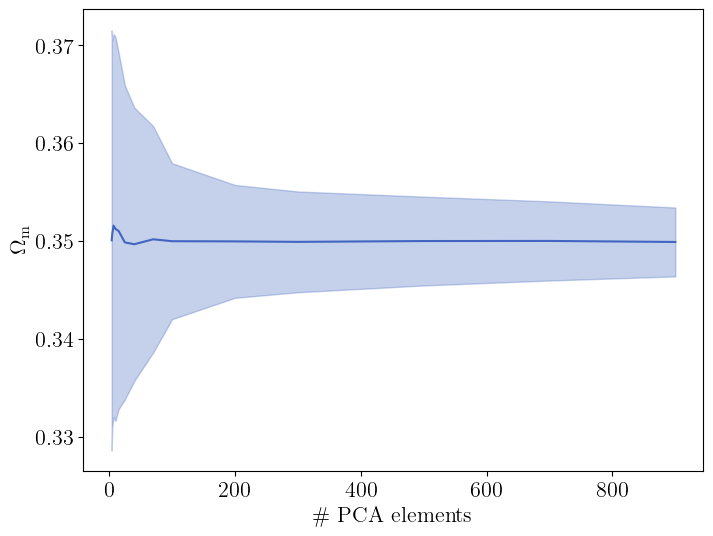

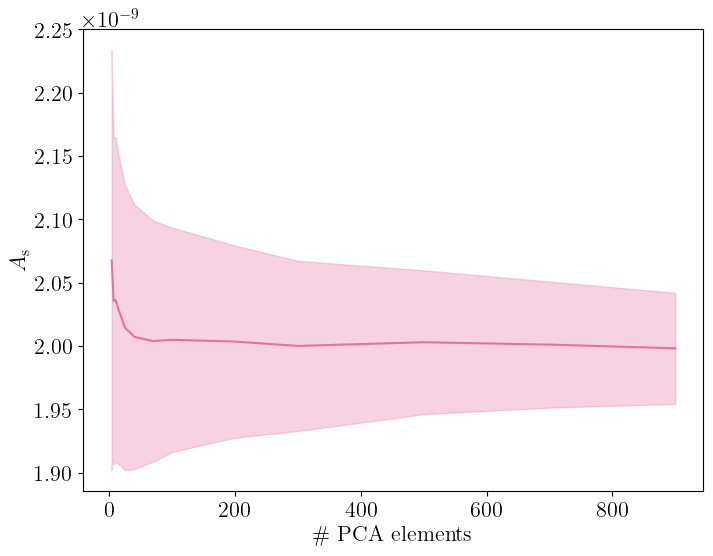

In [53]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas[2:],omega_m_means[2:],color='#4165c0')
plt.fill_between(N_pcas[2:], omega_m_means[2:]-omega_m_sigmas[2:], omega_m_means[2:]+omega_m_sigmas[2:], color='#4165c0',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$\Omega_\mathrm{m}$')
plt.savefig('data_4_assignment3/plots/pca_Omegam_cut.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.plot(N_pcas[2:],As_means[2:],color='#e770a2')
plt.fill_between(N_pcas[2:], As_means[2:]-As_sigmas[2:], As_means[2:]+As_sigmas[2:], color='#e770a2',alpha=0.3)
plt.xlabel('\# PCA elements')
plt.ylabel('$A_\mathrm{s}$')
plt.savefig('data_4_assignment3/plots/pca_As_cut.jpg',dpi=600, bbox_inches='tight')
plt.show()

#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

In [54]:
parameter_constraints_100 = []

for i in range(16):
    pca,model,cov_inv = make_pca_parts(100,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size()

    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]]
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]])

    parameter_constraints_100.append([means,sigmas])

parameter_constraints_100 = np.array(parameter_constraints_100)

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints_100',parameter_constraints_100)

100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:24<00:00,  4.03it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:31<00:00,  3.99it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:26<00:00,  4.02it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:28<00:00,  4.01it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:30<00:00,  3.70it/s]


Removed no burn in


100%|██████████| 3000/3000 [14:11<00:00,  3.52it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:56<00:00,  3.86it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:44<00:00,  3.64it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:12<00:00,  3.79it/s]

Removed no burn in


In [55]:
#parameter_constraints_100 = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints_100.npy')

omega_m_means = parameter_constraints_100[:,0,0]
As_means = parameter_constraints_100[:,0,1]
omega_m_sigmas = parameter_constraints_100[:,1,0]
As_sigmas = parameter_constraints_100[:,1,1]

In [56]:
print('omega_m mean:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_means),np.std(omega_m_means)))
print('omega_m sigma:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_sigmas),np.std(omega_m_sigmas)))
print('As mean:\t {:.4e} ± {:.2e}'.format(np.mean(As_means),np.std(As_means)))
print('As sigma:\t {:.4e} ± {:.2e}'.format(np.mean(As_sigmas),np.std(As_sigmas)))

omega_m mean:	 0.34990 ± 0.00014
omega_m sigma:	 0.00802 ± 0.00006
As mean:	 2.0039e-09 ± 1.18e-12
As sigma:	 8.7704e-11 ± 6.07e-13


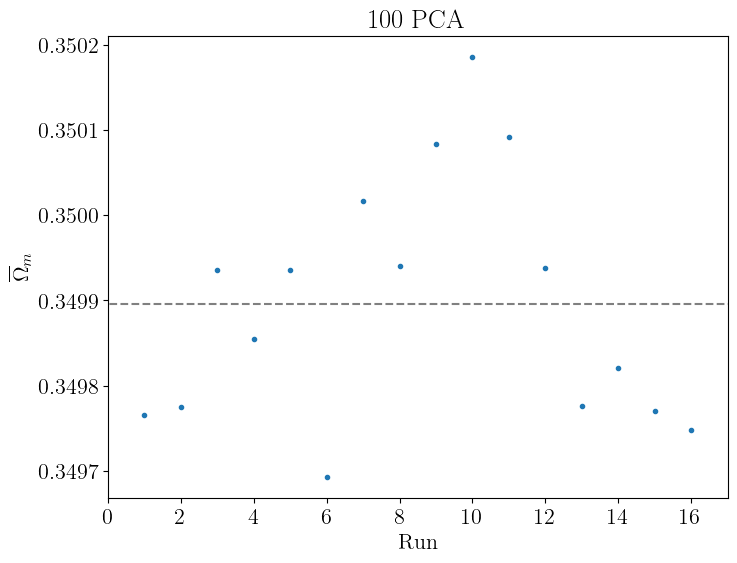

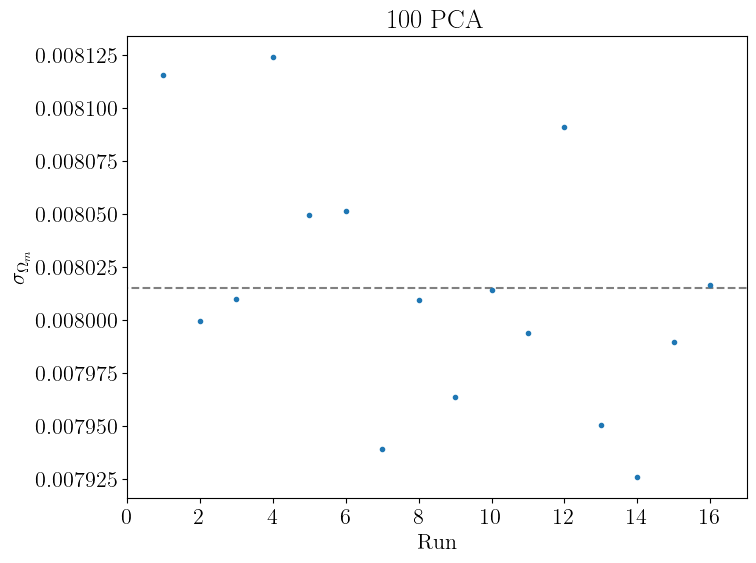

In [57]:
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_means)+1),omega_m_means,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run')
plt.ylabel('$\overline\Omega_m$')
plt.savefig('data_4_assignment3/plots/pca100_Omegam_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_sigmas)+1),omega_m_sigmas,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run')
plt.ylabel('$\sigma_{\Omega_m}$')
plt.savefig('data_4_assignment3/plots/pca100_Omegam_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

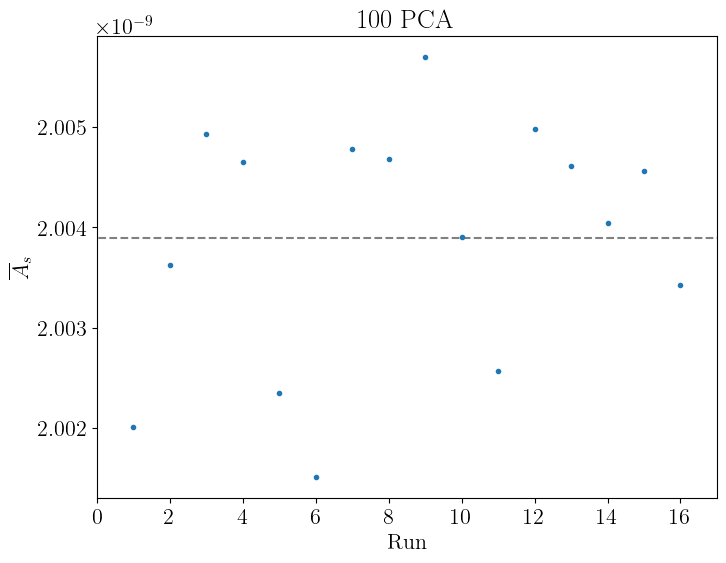

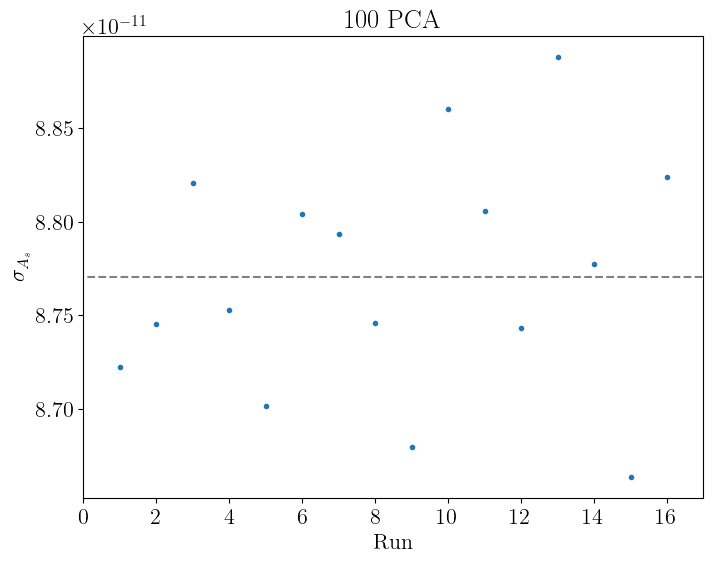

In [58]:
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_means)+1),As_means,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run')
plt.ylabel('$\overline A_s$')
plt.savefig('data_4_assignment3/plots/pca100_As_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_sigmas)+1),As_sigmas,'.')
plt.xlim(0,17)
plt.title('100 PCA')
plt.xlabel('Run')
plt.ylabel('$\sigma_{A_s}$')
plt.savefig('data_4_assignment3/plots/pca100_As_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

In [59]:
parameter_constraints_600 = []

for i in range(16):
    pca,model,cov_inv = make_pca_parts(600,cov_num_1500,reference_model,True)
    
    p0 = start_position_lh_and_step_size()

    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p0, total_steps, progress=True)

    samples_getdist = MCSamples(samples=sampler.get_chain(discard=burning_steps,flat=True), settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    means = samples_getdist.getMeans()[[0,2]]
    sigmas = np.sqrt(samples_getdist.getVars()[[0,2]])

    parameter_constraints_600.append([means,sigmas])

parameter_constraints_600 = np.array(parameter_constraints_600)

np.save('data_4_assignment3/outputs_MCMC/parameter_constraints_600',parameter_constraints_600)

100%|██████████| 3000/3000 [13:19<00:00,  3.75it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:12<00:00,  3.79it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:50<00:00,  3.89it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:53<00:00,  3.88it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:46<00:00,  3.91it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:10<00:00,  3.79it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:11<00:00,  3.79it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:53<00:00,  3.60it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:54<00:00,  3.59it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:32<00:00,  3.69it/s]


Removed no burn in


100%|██████████| 3000/3000 [15:10<00:00,  3.30it/s]


Removed no burn in


100%|██████████| 3000/3000 [14:01<00:00,  3.57it/s]


Removed no burn in


100%|██████████| 3000/3000 [13:42<00:00,  3.65it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:34<00:00,  3.97it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:36<00:00,  3.97it/s]


Removed no burn in


100%|██████████| 3000/3000 [12:28<00:00,  4.01it/s]

Removed no burn in


In [60]:
#parameter_constraints_600 = np.load('data_4_assignment3/outputs_MCMC/parameter_constraints_600.npy')

omega_m_means = parameter_constraints_600[:,0,0]
As_means = parameter_constraints_600[:,0,1]
omega_m_sigmas = parameter_constraints_600[:,1,0]
As_sigmas = parameter_constraints_600[:,1,1]

In [61]:
print('omega_m mean:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_means),np.std(omega_m_means)))
print('omega_m sigma:\t {:.5f} ± {:.5f}'.format(np.mean(omega_m_sigmas),np.std(omega_m_sigmas)))
print('As mean:\t {:.4e} ± {:.2e}'.format(np.mean(As_means),np.std(As_means)))
print('As sigma:\t {:.4e} ± {:.2e}'.format(np.mean(As_sigmas),np.std(As_sigmas)))

omega_m mean:	 0.34999 ± 0.00007
omega_m sigma:	 0.00425 ± 0.00002
As mean:	 2.0009e-09 ± 9.51e-13
As sigma:	 5.3740e-11 ± 3.07e-13


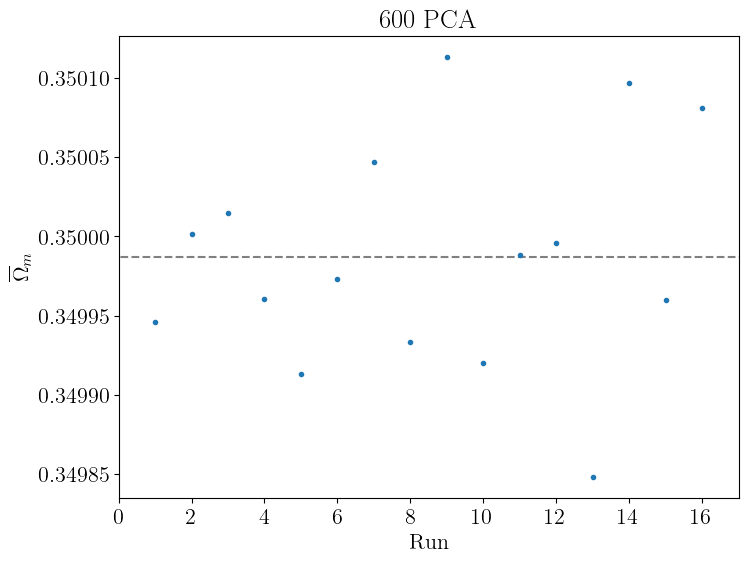

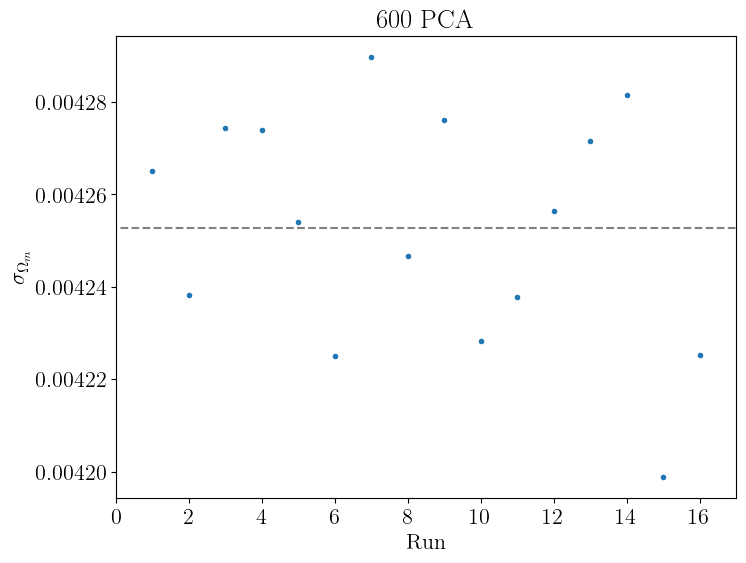

In [62]:
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_means)+1),omega_m_means,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run')
plt.ylabel('$\overline\Omega_m$')
plt.savefig('data_4_assignment3/plots/pca600_Omegam_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(omega_m_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(omega_m_sigmas)+1),omega_m_sigmas,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run')
plt.ylabel('$\sigma_{\Omega_m}$')
plt.savefig('data_4_assignment3/plots/pca600_Omegam_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

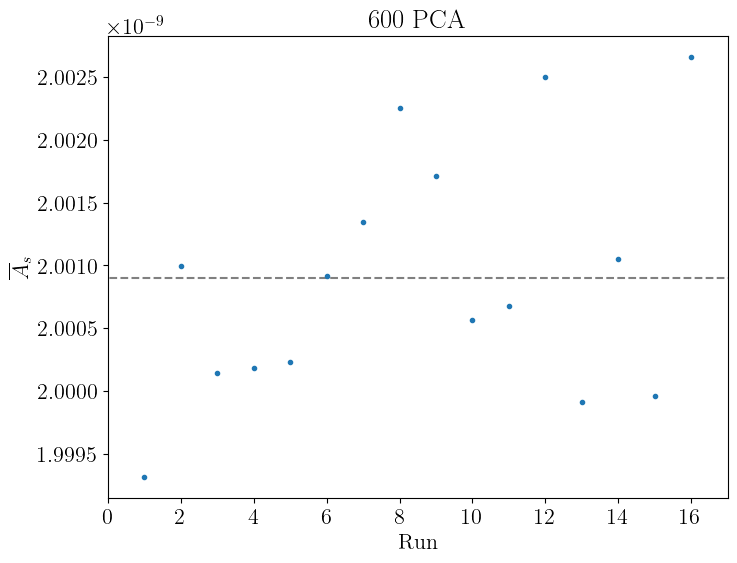

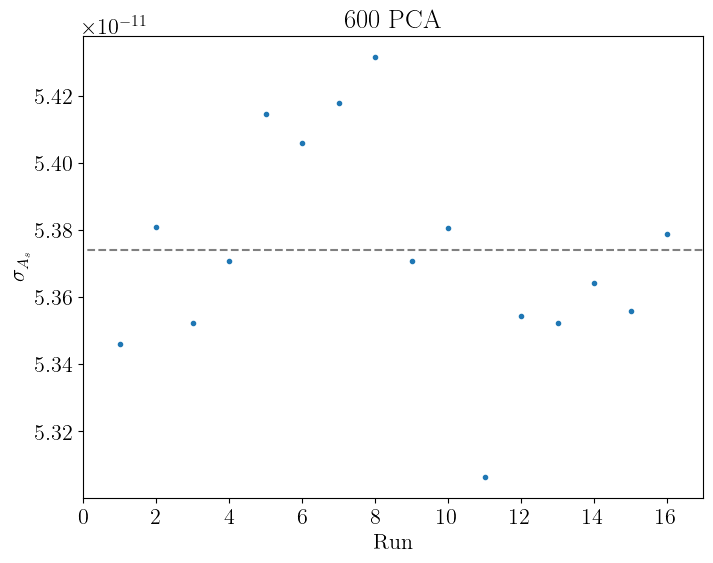

In [63]:
plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_means),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_means)+1),As_means,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run')
plt.ylabel('$\overline A_s$')
plt.savefig('data_4_assignment3/plots/pca600_As_mean.jpg',dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6),dpi=100)
plt.hlines(np.mean(As_sigmas),-5,20,'grey','--')
plt.plot(np.arange(1,len(As_sigmas)+1),As_sigmas,'.')
plt.xlim(0,17)
plt.title('600 PCA')
plt.xlabel('Run')
plt.ylabel('$\sigma_{A_s}$')
plt.savefig('data_4_assignment3/plots/pca600_As_std.jpg',dpi=600, bbox_inches='tight')
plt.show()

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###

In [ ]:
# idk man